In [ ]:
from faker import Faker
import random
import redshift_connector
import pandas as pd
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

In [2]:
from faker import Faker
import random
import pandas as pd

In [ ]:
%load_ext sql

# OLTP Implementation of Music Streaming Service

## OLTP ERD

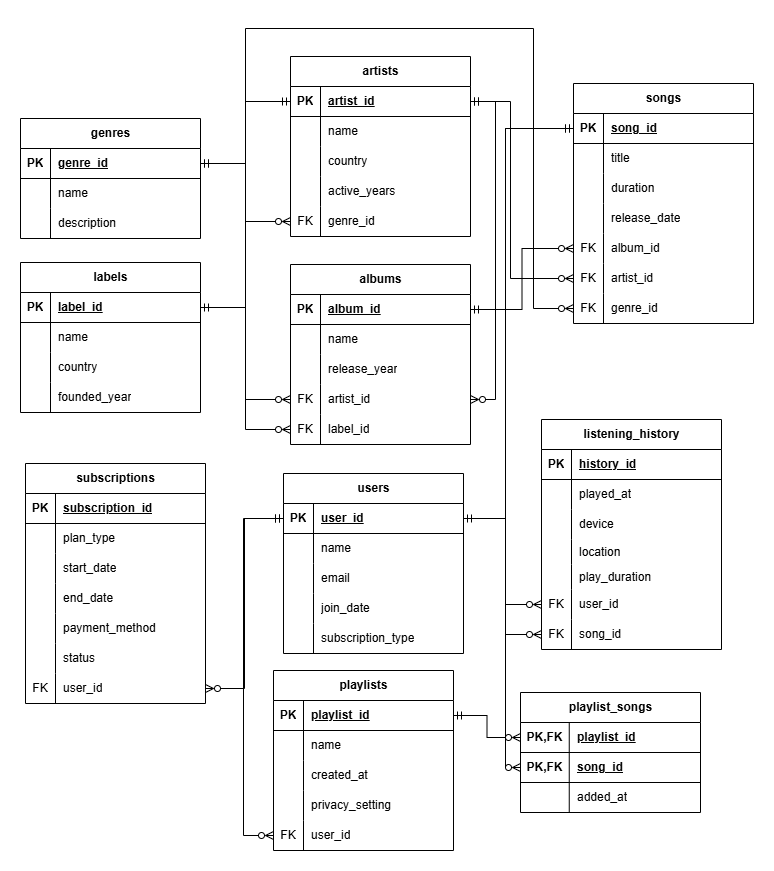

## RDS Console Details

In [ ]:
config = Config(RepositoryEnv("../db_pass.txt"))
db_oltp_password = config("oltp_pass")
oltp_connection = config("oltp_connection")

In [ ]:
connection_string = f"postgresql://vincent:{db_oltp_password}@{oltp_connection}/music_streaming_service"

In [ ]:
engine = create_engine(connection_string)

In [ ]:
get_ipython().run_line_magic('sql', connection_string)

## Create Table Scripts

In [ ]:
%%sql
CREATE TABLE genres (
    genre_id SERIAL PRIMARY KEY,
    name TEXT,
    description TEXT
);

CREATE TABLE labels (
    label_id SERIAL PRIMARY KEY,
    name TEXT,
    country TEXT,
    founded_year INT
);

CREATE TABLE artists (
    artist_id SERIAL PRIMARY KEY,
    name TEXT,
    country TEXT,
    active_years TEXT,
    genre_id INT,
    FOREIGN KEY (genre_id) REFERENCES genre(genre_id)
);

CREATE TABLE albums (
    album_id SERIAL PRIMARY KEY,
    name TEXT,
	release_year INT
    artist_id INT,
    label_id INT,
    FOREIGN KEY (artist_id) REFERENCES artists(artist_id),
    FOREIGN KEY (label_id) REFERENCES labels(label_id)
);

CREATE TABLE songs (
    song_id SERIAL PRIMARY KEY,
    title TEXT,
    duration INT,
    album_id INT,
    artist_id INT,
    genre_id INT,
    release_date DATE,
    FOREIGN KEY (album_id) REFERENCES albums(album_id),
    FOREIGN KEY (artist_id) REFERENCES artist(artist_id),
    FOREIGN KEY (genre_id) REFERENCES genres(genre_id)
);

CREATE TABLE users (
    user_id SERIAL PRIMARY KEY,
    name TEXT,
    email TEXT,
    join_date DATE,
    subscription_type TEXT
);

CREATE TABLE playlists (
    playlist_id SERIAL PRIMARY KEY,
    name TEXT,
    created_at TIMESTAMP,
    privacy_setting TEXT,
	user_id INT,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE playlist_songs (
    playlist_id INT,
    song_id INT,
	PRIMARY KEY (playlist_id, song_id),
    added_at TIMESTAMP,
    FOREIGN KEY (playlist_id) REFERENCES playlists(playlist_id),
    FOREIGN KEY (song_id) REFERENCES songs(song_id)
);


CREATE TABLE listening_history (
    history_id SERIAL PRIMARY KEY,
	played_at TIMESTAMP,
	device TEXT,
	location TEXT,
	play_duration INT,
    user_id INT,
    song_id INT,
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (song_id) REFERENCES songs(song_id)
);

CREATE TABLE subscriptions (
    subscription_id SERIAL PRIMARY KEY,
	plan_type TEXT,
	start_date DATE,
	end_date DATE,
	payment_method TEXT,
	status TEXT,
	user_id INT,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

## List of Databases

In [ ]:
%sql \l

## List of tables in oltp music_streaming_service database

In [ ]:
%sql \dt

In [ ]:
table_list = [
    "genres", "labels", "artists", "albums",
    "songs", "users", "playlists", "playlist_songs",
    "listening_history", "subscriptions"
]

## Schema of tables

In [ ]:
for table in table_list:
    print(f"{table}")
    schema_query = f"columns --table {table}"
    display(get_ipython().run_line_magic('sqlcmd', schema_query))

## Faker to create dummy data

In [52]:
fake = Faker()

music_genres = [
    "Rock", "Jazz", "Hip-Hop", "Electronic", "Classical", 
    "Pop", "Blues", "Reggae", "Country", "Metal", 
    "Funk", "R&B", "Soul", "Punk", "Disco"
]

sub_type = ["Free", "Basic", "Premium"]

def generate_oltp_genre(n):
    data = []
    for i in range(n):
        data.append((
            i,
            music_genres[i-1],
            fake.text()
        ))
    return data

def generate_oltp_labels(n):
    data = []
    for i in range(n):
        data.append((
            i,
            fake.company(),
            fake.country(),
            fake.year()
        ))
    return data

def generate_oltp_artists(n):
    data = []
    for i in range(n):
        fk_yr = fake.year()
        data.append((
            i,
            fake.name(),
            fake.country(),
            f"{int(fk_yr)-3}-{int(fk_yr)+3}",
            fake.random_int(0, 15)
        ))
    return data

def generate_oltp_albums(n):
    data = []
    for i in range(n):
        data.append((
            i,
            f"{fake.word()} {fake.word()} {fake.word()}",
            fake.year(),
            fake.random_int(0, 25),
            fake.random_int(0, 25)
        ))
    return data

def generate_oltp_songs(n):
    data = []
    for i in range(n):
        data.append((
            i,
            f"{fake.word()} {fake.word()} {fake.word()}",
            fake.random_int(120, 320),
            fake.random_int(0, 25),
            fake.random_int(0, 25),
            fake.random_int(0, 15),
            fake.date()
        ))
    return data

def generate_oltp_users(n):
    data = []
    for i in range(n):
        data.append((
            i,
            fake.name(),
            fake.email(),
            fake.date(),
            random.choice(sub_type)
        ))
    return data

def generate_oltp_playlist(n):
    data = []
    for i in range(n):
        data.append((
            i,
            f"{fake.word()} {fake.word()} {fake.word()}",
            fake.date_time(),
            random.choice(["private, public"]),
            fake.random_int(0, 100)
        ))
    return data

def generate_oltp_playlist_songs(n):
    data = []
    for i in range(n):
        data.append((
            fake.random_int(0, 300),
            fake.random_int(0, 100),
            fake.date_time()
        ))
    return data

def generate_oltp_listening_history(n):
    data = []
    for i in range(n):
        data.append((
            i,
            fake.date_time(),
            random.choice(["mobile", "desktop"]),
            fake.city(),
            fake.random_int(1000, 3000),
            fake.random_int(0, 100),
            fake.random_int(0, 300)
        ))
    return data

def generate_oltp_subscriptions(n):
    data = []
    for i in range(n):
        data.append((
            i,
            random.choice(sub_type),
            fake.date_time(),
            fake.date_time(),
            random.choice(["debit card", "mobile wallet", "credit card"]),
            random.choice(["expired", "active", "inactive"]),
            fake.random_int(0, 100)
        ))
    return data

def save_to_postgres(df, table_name, engine):
    df.to_sql(table_name, engine, if_exists='append', index=False)

In [ ]:
df_genre = pd.DataFrame(
    generate_oltp_genre(16), 
    columns=["genre_id", "name", "description"]
)
df_label = pd.DataFrame(
    generate_oltp_labels(26), 
    columns=["label_id", "name", "country", "founded_year"]
)
df_artist = pd.DataFrame(
    generate_oltp_artists(26), 
    columns=["artist_id", "name", "country", "active_years", "genre_id"]
)
df_album = pd.DataFrame(
    generate_oltp_albums(26), 
    columns=["album_id", "name", "release_year", "artist_id", "label_id"]
)
df_song = pd.DataFrame(
    generate_oltp_songs(100), 
    columns=["song_id", "title", "duration", "album_id", "artist_id", "label_id", "release_date"]
)
df_user = pd.DataFrame(
    generate_oltp_users(100), 
    columns=["user_id", "name", "email", "join_date", "subscription_type"]
)
df_playlist_songs = pd.DataFrame(
    generate_oltp_playlist_songs(300), 
    columns=["playlist_id", "song_id", "added_at"]
)
df_playlist = pd.DataFrame(
    generate_oltp_playlist(150), 
    columns=["playlist_id", "name", "created_at", "privacy_setting", "user_id"]
)
df_listening_history = pd.DataFrame(
    generate_oltp_listening_history(200), 
    columns=["history_id", "played_at", "device", "location", "play_duration", "user_id", "song_id"]
)
df_subscription = pd.DataFrame(
    generate_oltp_subscriptions(200), 
    columns=["subscription_id", "plan_type", "start_date", "end_date", "payment_method", "status", "user_id"]
)

save_to_postgres(df_genre, "genres", engine)
save_to_postgres(df_label, "labels", engine)
save_to_postgres(df_artist, "artists", engine)
save_to_postgres(df_album, "albums", engine)
save_to_postgres(df_song, "songs", engine)
save_to_postgres(df_user, "users", engine)
save_to_postgres(df_playlist_songs, "playlist_songs", engine)
save_to_postgres(df_playlist, "playlists", engine)
save_to_postgres(df_listening_history, "listening_history", engine)
save_to_postgres(df_subscription, "subscriptions", engine)

## First 100 rows of each table

In [ ]:
for table in table_list:
    print(f"{table}")
    display(pd.read_sql(f"select * from {table}", engine))

## Number of rows of each table

In [ ]:
for table in table_list:
    print(f"{table}")
    count_query = f"select COUNT(*) from {table}"
    display(get_ipython().run_line_magic('sql', count_query))

## Rollback/Start from scratch queries

# OLAP Implementation of Music Streaming Service

In [ ]:
db_olap_password = config("olap_pass")
olap_connection = config("olap_connection")

In [ ]:
connection_string = f"postgresql+psycopg2://vincent:{db_olap_password}@{olap_connection}:5439/music_streaming_service"

In [ ]:
engine = redshift_connector.connect(
    host=olap_connection,
    port=5439,
    database='music_streaming_service',
    user='vincent',
    password=db_password
)

In [ ]:
get_ipython().run_line_magic('sql', connection_string)